In [50]:
# from ASCID_variable import *
# from ASCID_analysis import *
import numpy as np
import matplotlib.pyplot as plt
from natsort import natsorted
import os
import csv
import pandas as pd
from scipy.optimize import curve_fit
import glob
import pickle
from matplotlib.colors import LogNorm

In [51]:
format(0.111233, '.2e')

'1.11e-01'

In [52]:
def label(x,y,a,b,pur="all"):
    plt.xlabel(x,fontsize=18)
    plt.ylabel(y,fontsize=18)
    if pur=="all":
        plt.rcParams['figure.figsize'] = [a,b]
    elif pur=="chi2":
        plt.title("Chi2 Analysis, S-%s, Channel %s"%(a,b), fontsize=20)
    plt.tick_params(axis='x', labelsize=14)
    plt.tick_params(axis='y', labelsize=14)
    return 

def gaus_fit(ri,rf,fx,fy,nm="norm"):
    from scipy.optimize import curve_fit
    def gaus(x,a,x0,sigma):
        return a*np.exp(-(x-x0)**2/(2*sigma**2))
    from scipy.stats import chisquare
    b=len(bins)-1
    hist_PI=[]
    for j in range(b):
        if ri<=bins[j]<=rf:                                                          #Bins range for gauss fit
            hist_PI.extend([j])
    x=bins[hist_PI]-(bins[1]-bins[0])/2
    y=n[hist_PI]
    l = len(x)
    mean = sum(x * y) / sum(y)
    sigma = np.sqrt(sum(y * (x - mean)**2) / sum(y))#the number of data
    popt,pcov = curve_fit(gaus,x,y, p0=[max(y), mean, sigma])
    m=x[1]-x[0]
    X=np.arange(x.min(),x.max(),m/10)
#     chi2=chisquare(n[hist_PI],f_exp=gaus(x,*popt))
#     b=chi2[0]/(len(hist_PI)-3)
    if nm=="norm":
        textstr = '\n'.join((
        r'$\mu=%.2f \pm %.2f$ ADC' % (popt[1], np.sqrt(pcov[1,1])),
        r'$\sigma=%.2f \pm %.2f$ ADC' % (popt[2], np.sqrt(pcov[2,2]))
        ))               #"r'$\chi^2/Dof=%.2f$' % (b, )"
    elif nm=="keV":
        textstr = '\n'.join((
            r'$\mu=%.2f \pm %.1f$ keV' % (popt[1], np.sqrt(pcov[1,1])),
            r'$\sigma=%.2f \pm %.1f$ keV' % (popt[2], np.sqrt(pcov[2,2]))
            )) 
    elif nm=="keV_br":
        textstr = '\n'.join((
            r'$\mu=%.2f \pm %.2f$ eV' % (popt[1]*1000, np.sqrt(pcov[1,1])*1000),
            r'$\sigma=%.2f \pm %.2f$ eV' % (popt[2]*1000, np.sqrt(pcov[2,2])*1000)
            ))               #"r'$\chi^2/Dof=%.2f$' % (b, )"
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    plt.text(fx, fy, textstr, fontsize=12,
             verticalalignment='top', bbox=props)
    return popt[0], popt[1],popt[2],plt.plot(X,gaus(X,*popt),'r')

# Data

In [53]:
N_det=26+11
Det_Comb=21

energyThreshold = 100
timeWindow=5e-7
Date="103024"
         #Not required if you are doing the full run. 
#first cut_data event or 2nd, Ex: index=0 means collecting first 60 second of data and 
                                 #index=1 means collecting second 60 second of data and so on...     
# run_index=0      #int(sys.argv[1])    #Type the index of run mentioned in the data file, required while taking multiple dataset 


activity = 0.47
cut_data= 900               #Select the required second of data
read_folder_all=glob.glob("../RUN5/Sc46/DAQ/CsI_Sc46_Take4*")                   #reading data folder
Total_folder = len(read_folder_all)
read_folder_all.sort(key=lambda x: os.stat(x).st_ctime)
folder_index = 21
read_folder= read_folder_all[folder_index]            #glob.glob("../RUN4/Sc46/DAQ/*")
save_folder="../RUN5/Sc46/Figures/Take4_2" 

print(f"Folder name {read_folder_all[folder_index]}")
index=0

innerChannel=np.arange(16,26)

date="%s"%(Date)
serial=np.array(["1st","2nd","3rd","4th","5th","6th", "7th", "8th"])
save_folder_each = os.path.join(save_folder, "Folder_%d"%folder_index)

Folder name ../RUN5/Sc46/DAQ\CsI_Sc46_Take4_21


In [54]:
files = glob.glob('%s/RAW/*.CSV'%read_folder)
files=natsorted(files)#[0:26]
# files = files
# print(files)
MinTime=np.zeros(N_det)
for nf,nfile in enumerate(files):
    # nfile1 = os.path.join(folder_path, nfile)
    file = open(nfile)
    csvreader = csv.reader(file, delimiter = ';')
    header = next(csvreader)
    line_count = 0
    for row in csvreader:
        if line_count == 0:
            MinTime[nf] = float(row[2]) * 1e-12
            break
minTime=np.min(MinTime)


# In[5]:

data=[]
for j in range(3):                                     #3=channel, time, calib. energy
    b=[]
    data.append(b)
nEvent=np.zeros(len(files))
for nf,nfile in enumerate(files):
    # nfile1 = os.path.join(folder_path, nfile)
    file = open(nfile)
    csvreader = csv.reader(file, delimiter = ';')
    header = next(csvreader)
    line_count = 0
    for row in csvreader:
        if float(row[2])*1e-12 - minTime>=cut_data*index:
            data[0].append(int(row[1]))
            data[1].append(float(row[2])*1e-12 - minTime)
            data[2].append(float(row[3]))     # row[4] = Caliberated energy, row[3] = ADC energy sometime, else row[3] = Caliberated energy
            line_count += 1
            # if line_count%1000000==0:
            #     print("%d M data loaded"%int(line_count/1000000))
            if float(row[2])*1e-12 - minTime>cut_data*(index+1):
                data[0].pop()
                data[1].pop()
                data[2].pop()
                break
    nEvent[nf]=line_count-1
    print("file %d done"%nf)
nEvents=int(nEvent.sum())


Data_Time=round((data[1][nEvents-1]-data[1][0]),0)
print("Total Time for this data set is %d s"%Data_Time)

file 0 done
file 1 done
file 2 done
file 3 done
file 4 done
file 5 done
file 6 done
file 7 done
file 8 done
file 9 done
file 10 done
file 11 done
file 12 done
file 13 done
file 14 done
file 15 done
file 16 done
file 17 done
file 18 done
file 19 done
file 20 done
file 21 done
file 22 done
file 23 done
file 24 done
file 25 done
file 26 done
file 27 done
file 28 done
file 29 done
file 30 done
file 31 done
file 32 done
file 33 done
file 34 done
file 35 done
file 36 done
Total Time for this data set is 900 s


In [55]:
data=np.array(data).T
data=data[data[:, 1].argsort()]
data=np.array(data).T

In [56]:
save_folder_each

'../RUN5/Sc46/Figures/Take4_2\\Folder_21'

In [57]:
energy_source = 889
# save_folder_each = "%s/Folder_%d"%(save_folder, folder_index)

f = open('%s/Calibration_parameter_folder%d_index%d.pickle'%(save_folder_each, folder_index, index), 'rb')
dat = pickle.load(f)
mean=dat['Mean']
f.close()

nEvents = len(data[0])
for j in range(nEvents):
    if data[0][j]<26:
        data[2][j]=data[2][j]/mean[int(data[0][j]), 0]*energy_source
print("Calibration done")

Calibration done


In [58]:
data_process = np.array(data).T
N_det_panel = 11
N_det_CsI = 26
energyThreshold_CsI = 100    #in keV
energyThreshold_Veto = 8 #in ADC, equivalent ~120 keV
energyThreshold = [energyThreshold_CsI, energyThreshold_Veto]
# Threshold arrays
Veto_threshold = np.ones(N_det_panel) * energyThreshold[1]
Threshold_CsI = np.ones(N_det_CsI) * energyThreshold[0]
Threshold_null = np.zeros(15)
Threshold = np.concatenate((Threshold_CsI, Threshold_null, Veto_threshold))

# Boolean mask to filter rows that meet the threshold condition
mask = data_process[:, 2] > Threshold[data_process[:, 0].astype(int)]

# Filtered data without intermediate list creation
data = data_process[mask, :3].T

In [59]:
nEvents = len(data[0])
csiCh = np.arange(26)
innerCh=np.arange(16,26,1)
VetoCh = np.arange(41, 52, 1)
timeWindow = 5e-7
Sig_index=-1
eventTime=0
Timed_Energy_event=[]
for j in range(nEvents):
    if  data[1][j]>eventTime+2*timeWindow and data[0][j] in csiCh:   #Avoiding center detector overlap
        eventTime=data[1][j]
        eventChannel=int(data[0][j])
        Ev_indx=j
        Sig_index+=1
        EventEnergy=data[2][j]
        a=[]
        a.extend([Ev_indx])
        
        while Ev_indx>0 and abs(data[1][Ev_indx-1]-eventTime)<=timeWindow:
            Ev_indx-=1
            a.extend([Ev_indx])
        Ev_indx=j
        
        while Ev_indx<nEvents-1 and abs(data[1][Ev_indx+1]-eventTime)<=timeWindow:
            Ev_indx+=1    
            a.extend([Ev_indx])
        a = np.unique(np.sort(a)) # a contains the index within the defined coincidence window
        Timed_Energy_event.extend([a])
    if j%1000000==0:
        print("%d M done"%int(j/1000000))
# Timed_Energy_event = Timed_Energy_event
# Timed_Energy_event=[]
print("data coincidence done")

0 M done
1 M done
2 M done
3 M done
4 M done
5 M done
6 M done
7 M done
8 M done
9 M done
10 M done
11 M done
12 M done
13 M done
14 M done
15 M done
16 M done
17 M done
18 M done
19 M done
20 M done
21 M done
22 M done
23 M done
24 M done
25 M done
26 M done
27 M done
28 M done
29 M done
30 M done
31 M done
32 M done
33 M done
34 M done
35 M done
36 M done
37 M done
38 M done
39 M done
40 M done
data coincidence done


In [83]:
min_val_1132 = mu2 - 1.5 * sigma2
max_val_1132 = mu2 + 1.5 * sigma2


sl=[]
VetoCh_set = set(VetoCh)
for k,j in enumerate(Timed_Energy_event):
    event_Channel = data[0][j]
    event_Energies = data[2][j]
    vetoMatch = VetoCh_set.intersection(event_Channel)
    if not vetoMatch:
        if any(min_val_1132 <= element <= max_val_1132 for element in event_Energies):
            sl.extend([k])

print("done")
energyRest_1132tagged = []
multipliciy_1132 = np.zeros(N_det_CsI)
for k in range(len(sl)):
    j = Timed_Energy_event[sl[k]]
    event_Channel = data[0][j]
    event_Energies = data[2][j]
    count_select = 0
    for element in event_Energies:
        if min_val_1132 <= element <= max_val_1132:
            energy_select = element
            count_select+=1
    energy_rest = sum(event_Energies) - energy_select
    energyRest_1132tagged.extend([energy_rest])
    multipliciy_1132[len(j)]+=1

done


In [60]:
min_val = mu1 - 1.5 * sigma1
max_val = mu1 + 1.5 * sigma1

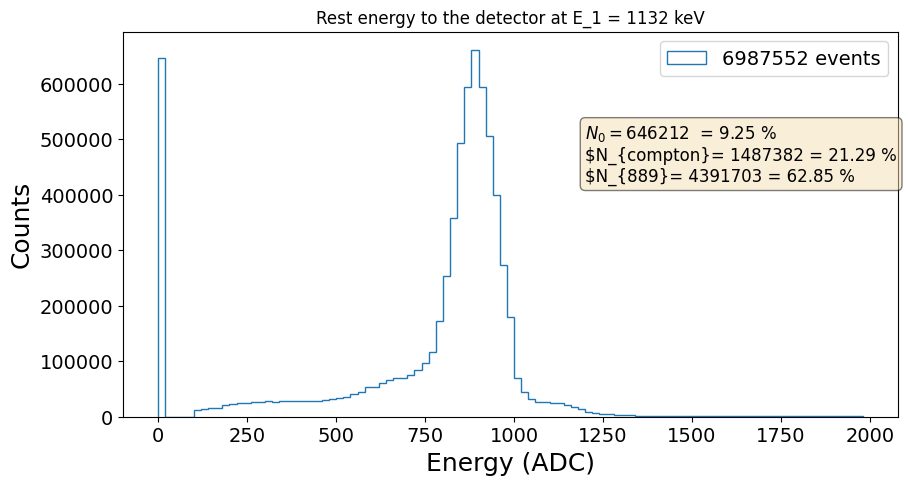

In [88]:
n,bins, patches=plt.hist(energyRest_1132tagged, bins=np.arange(0,2000, 20), histtype="step", label="%d events"%len(energyRest_1132tagged))
label("Energy (ADC)", "Counts", 10,5)

count_1132= np.zeros(3)
for j in energyRest_1132tagged:
    if j == 0:
        count_1132[0]+=1
    elif j<min_val:
        count_1132[1]+=1
    elif min_val<j<max_val:
        count_1132[2]+=1

plt.legend(fontsize=14)
textstr = '\n'.join((
            r'$N_0= %d$  = %.2f %%' % (count_1132[0], count_1132[0]/len(energyRest_1132tagged)*100),
            r'$N_{compton}= %d = %.2f %%' % (count_1132[1], count_1132[1]/len(energyRest_1132tagged)*100),
            r'$N_{889}= %d = %.2f %%' % (count_1132[2], count_1132[2]/len(energyRest_1132tagged)*100)
            ))               #"r'$\chi^2/Dof=%.2f$' % (b, )"
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(1200, max(n)*0.8, textstr, fontsize=12,
         verticalalignment='top', bbox=props)
plt.title("Rest energy to the detector at E_1 = 1132 keV", fontsize = 12)
plt.savefig("%s/EnergyRest_1132.jpg"%(save_folder_each))

In [85]:
sl=[]
VetoCh_set = set(VetoCh)
for k,j in enumerate(Timed_Energy_event):
    event_Channel = data[0][j]
    event_Energies = data[2][j]
    vetoMatch = VetoCh_set.intersection(event_Channel)
    if not vetoMatch:
        if any(min_val <= element <= max_val for element in event_Energies):
            sl.extend([k])

print("done")
energyRest_889tagged = []
multipliciy_889 = np.zeros(N_det_CsI)
for k in range(len(sl)):
    j = Timed_Energy_event[sl[k]]
    event_Channel = data[0][j]
    event_Energies = data[2][j]
    count_select = 0
    for element in event_Energies:
        if min_val <= element <= max_val:
            energy_select = element
            count_select+=1
    energy_rest = sum(event_Energies) - energy_select
    energyRest_889tagged.extend([energy_rest])
    multipliciy_889[len(j)]+=1

done


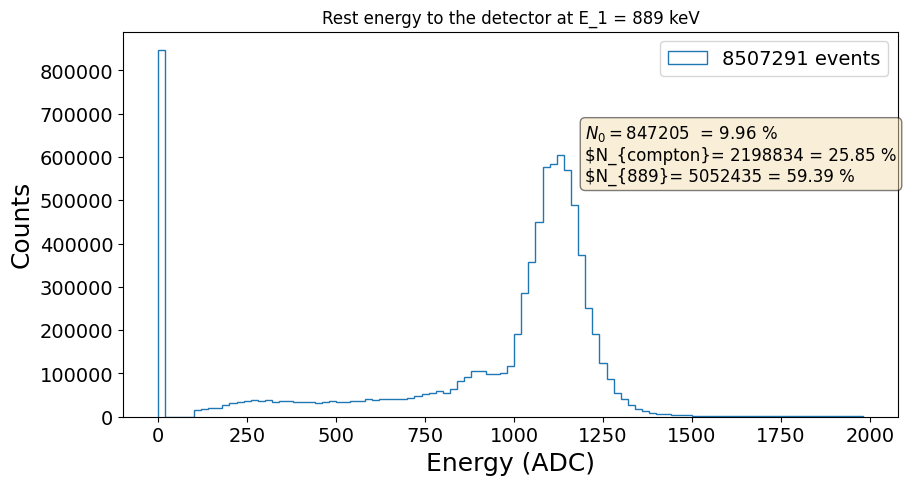

In [87]:
n,bins, patches=plt.hist(energyRest_889tagged, bins=np.arange(0,2000, 20), histtype="step", label="%d events"%len(energyRest_889tagged))
label("Energy (ADC)", "Counts", 10,5)

count_889= np.zeros(3)
for j in energyRest_889tagged:
    if j == 0:
        count_889[0]+=1
    elif j<min_val_1132:
        count_889[1]+=1
    elif min_val_1132<j<max_val_1132:
        count_889[2]+=1

plt.legend(fontsize=14)
textstr = '\n'.join((
            r'$N_0= %d$  = %.2f %%' % (count_889[0], count_889[0]/len(energyRest_889tagged)*100),
            r'$N_{compton}= %d = %.2f %%' % (count_889[1], count_889[1]/len(energyRest_889tagged)*100),
            r'$N_{889}= %d = %.2f %%' % (count_889[2], count_889[2]/len(energyRest_889tagged)*100)
            ))               #"r'$\chi^2/Dof=%.2f$' % (b, )"
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(1200, max(n)*0.8, textstr, fontsize=12,
         verticalalignment='top', bbox=props)
plt.title("Rest energy to the detector at E_1 = 889 keV", fontsize = 12)
plt.savefig("%s/EnergyRest_889.jpg"%(save_folder_each))

# Simulation

In [65]:
save_folder_sim="../Simulation/Sc46/Output_2" 


In [73]:
f = open('%s/OutputEnergy_Run-folder2.pickle'%(save_folder_sim), 'rb')
dat = pickle.load(f)
# mean=dat['Mean']
f.close()


In [74]:
Timed_SmEnergy_event = dat['Timed_SmEnergy_event']
Timed_SmEnergy_Channel = dat['Timed_SmEnergy_Channel']

In [36]:
Timed_SmEnergy_event[0]

[1110.2890199945898, 912.794963850379]

In [78]:
sl_sm=[[],[]]
VetoCh_set = set(VetoCh)
for k,j in enumerate(Timed_SmEnergy_event):
    event_Energies = j
    # vetoMatch = VetoCh_set.intersection(event_Channel)
    # if not vetoMatch:
    if any(min_val_1132 <= element <= max_val_1132 for element in event_Energies):
        sl_sm[0].extend([k])
    elif any(min_val <= element <= max_val for element in event_Energies):
        sl_sm[1].extend([k])

print("done")
energyRest_1132tagged_sm = []
multipliciy_1132_sm = np.zeros(N_det_CsI)
for k in range(len(sl_sm[0])):
    event_Energies = Timed_SmEnergy_event[sl_sm[0][k]]
    count_select = 0
    for element in event_Energies:
        if min_val_1132 <= element <= max_val_1132:
            energy_select = element
            count_select+=1
    energy_rest = sum(event_Energies) - energy_select
    energyRest_1132tagged_sm.extend([energy_rest])
    multipliciy_1132_sm[len(event_Energies)]+=1

print("done")
energyRest_889tagged_sm = []
multipliciy_889_sm = np.zeros(N_det_CsI)
for k in range(len(sl_sm[1])):
    event_Energies = Timed_SmEnergy_event[sl_sm[1][k]]
    count_select = 0
    for element in event_Energies:
        if min_val <= element <= max_val:
            energy_select = element
            count_select+=1
    energy_rest = sum(event_Energies) - energy_select
    energyRest_889tagged_sm.extend([energy_rest])
    multipliciy_889_sm[len(event_Energies)]+=1

done
done


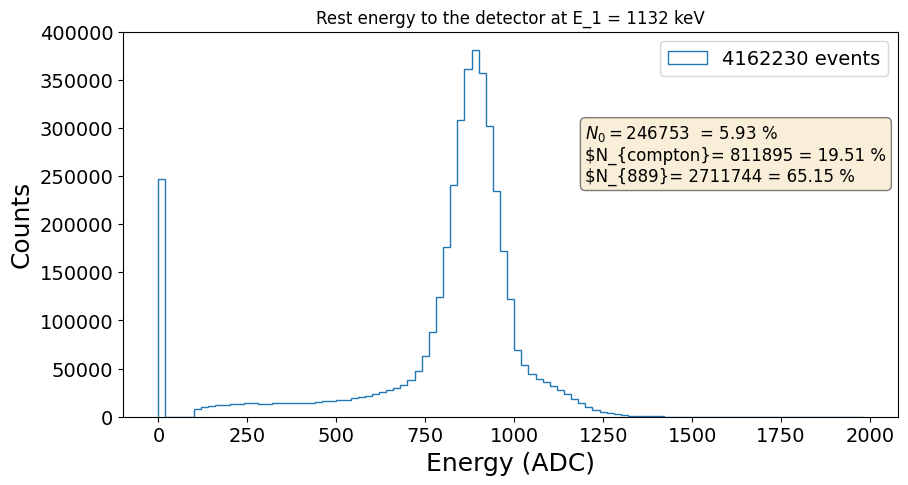

In [89]:
n1 = 1
n,bins, patches=plt.hist(energyRest_1132tagged_sm, bins=np.arange(0,2000, 20), histtype="step", label="%d events"%len(energyRest_1132tagged_sm))
label("Energy (ADC)", "Counts", 10,5)

count_1132= np.zeros(3)
for j in energyRest_1132tagged_sm:
    if j == 0:
        count_1132[0]+=1
    elif j<min_val:
        count_1132[1]+=1
    elif min_val<j<max_val:
        count_1132[2]+=1

plt.legend(fontsize=14)
textstr = '\n'.join((
            r'$N_0= %d$  = %.2f %%' % (count_1132[0], count_1132[0]/len(energyRest_1132tagged_sm)*100),
            r'$N_{compton}= %d = %.2f %%' % (count_1132[1], count_1132[1]/len(energyRest_1132tagged_sm)*100),
            r'$N_{889}= %d = %.2f %%' % (count_1132[2], count_1132[2]/len(energyRest_1132tagged_sm)*100)
            ))               #"r'$\chi^2/Dof=%.2f$' % (b, )"
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(1200, max(n)*0.8, textstr, fontsize=12,
         verticalalignment='top', bbox=props)
plt.title("Rest energy to the detector at E_1 = 1132 keV", fontsize = 12)
plt.savefig("%s/EnergyRest_1132_simulation.jpg"%(save_folder_each))

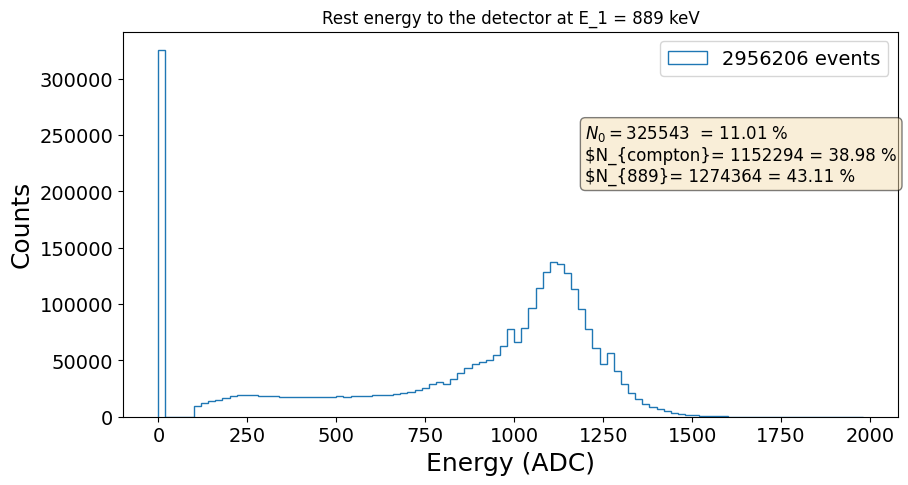

In [90]:
n1 = 1
n,bins, patches=plt.hist(energyRest_889tagged_sm, bins=np.arange(0,2000, 20), histtype="step", label="%d events"%len(energyRest_889tagged_sm))
label("Energy (ADC)", "Counts", 10,5)

count_889= np.zeros(3)
for j in energyRest_889tagged_sm:
    if j == 0:
        count_889[0]+=1
    elif j<min_val_1132:
        count_889[1]+=1
    elif min_val_1132<j<max_val_1132:
        count_889[2]+=1

plt.legend(fontsize=14)
textstr = '\n'.join((
            r'$N_0= %d$  = %.2f %%' % (count_889[0], count_889[0]/len(energyRest_889tagged_sm)*100),
            r'$N_{compton}= %d = %.2f %%' % (count_889[1], count_889[1]/len(energyRest_889tagged_sm)*100),
            r'$N_{889}= %d = %.2f %%' % (count_889[2], count_889[2]/len(energyRest_889tagged_sm)*100)
            ))               #"r'$\chi^2/Dof=%.2f$' % (b, )"
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(1200, max(n)*0.8, textstr, fontsize=12,
         verticalalignment='top', bbox=props)
plt.title("Rest energy to the detector at E_1 = 889 keV", fontsize = 12)
plt.savefig("%s/EnergyRest_889_simulation.jpg"%(save_folder_each))

In [92]:
len(energyRest_889tagged_sm)/ len(Timed_SmEnergy_event), len(energyRest_1132tagged_sm)/ len(Timed_SmEnergy_event)

(0.29864371055318784, 0.4204794291655571)

In [93]:
len(energyRest_889tagged)/ len(Timed_Energy_event), len(energyRest_1132tagged)/ len(Timed_Energy_event)

(0.49662551963074786, 0.4079085390339735)

In [67]:
f = open('%s/OutputTest_Run-folder2.pickle'%(save_folder_sim), 'rb')
dat = pickle.load(f)
# mean=dat['Mean']
f.close()

## Combined

# inclusive search

In [96]:
save_folder_each = 'D:/RUN5/Sc46/Figures/Result'

In [13]:
file = "%s/Result_Run5.pickle"%save_folder_each
f = open('%s'%(file), 'rb')
dat=pickle.load(f)
f.close()

In [16]:
f = open('%s'%(file), 'rb')
dat=pickle.load(f)
Bins=dat['Bins']
f.close()
Time = dat['Time']
n_EnergyAll_NVeto=dat['n_EnergyAll_NVeto']
n_EnergyInner_NVeto=dat['n_EnergyInner_NVeto']
Time/3600

329.7972222222222

In [14]:
for key, value in dat.items():
    print(key)

Run
Time
nEvent
Multiplicity
Multiplicity_raw
n_EnergyInner
n_EnergyAll
n_EnergyAll_NVeto
Bins
n_EnergyInner_NVeto
n_1det
count1det_ch


In [18]:
save_folder_sim = 'D:/Simulation/Sc46/Output_2'
f = open('%s/Output_Run-folder2.pickle'%(save_folder_sim), 'rb')
dat = pickle.load(f)
# mean=dat['Mean']
f.close()

n_EnergyAll = dat['n_EnergyAll']
n_EnergyInner = dat['n_EnergyInner']
bins_combined = dat['bins_combined']

In [24]:
Total_data = n_EnergyAll_NVeto.sum()
Total_sim = n_EnergyAll[5:125].sum()
sim_energy_match_All = np.array((n_EnergyAll*Total_data/Total_sim), dtype = 'int64')
sim_energy_match_Inner = np.array((n_EnergyInner*Total_data/Total_sim), dtype = 'int64')

Text(0.5, 1.0, 'Sc46 Co-added All spectrum, Data vs Simulation, 329.80 Hr')

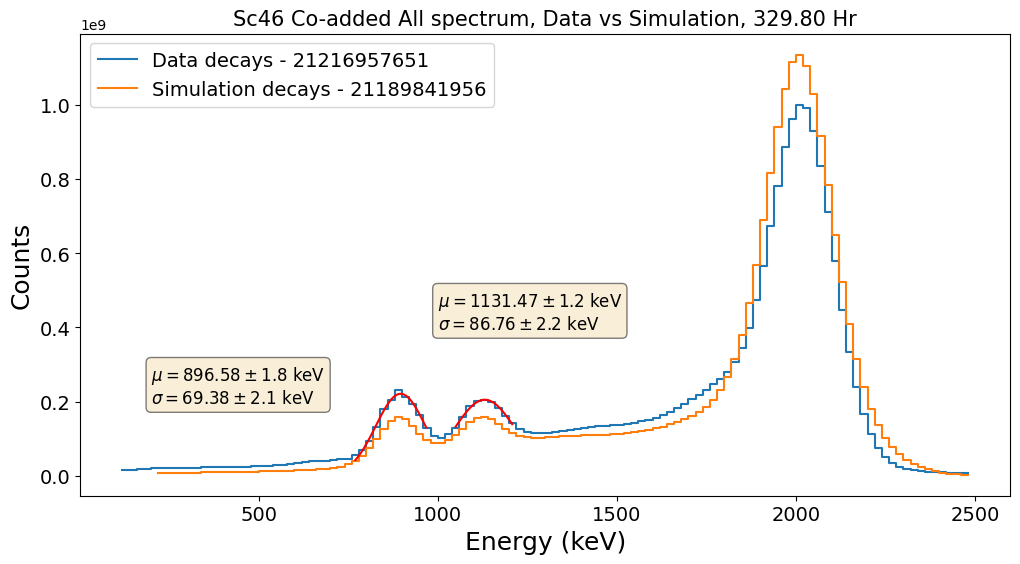

In [41]:
plt.step(Bins[1:], n_EnergyAll_NVeto, label = "Data decays - %d"%n_EnergyAll_NVeto.sum())
plt.step(bins_combined[1:][10:125], sim_energy_match_All[10:125], label = "Simulation decays - %d"%sim_energy_match_All[10:125].sum())
label("Energy (keV)", "Counts", 12, 6)
source = "Sc46"
n, bins = n_EnergyAll_NVeto, Bins[1:]
# gaus_fit(1850, 2200, 1200, 8e8, nm = "keV")
amp1, mu1, sigma1, fig = gaus_fit(770, 990, 200, 3e8, nm = "keV")
amp2, mu2, sigma2, fig = gaus_fit(1050, 1230, 1000, 5e8, nm = "keV")
plt.legend(fontsize = 14)
# plt.xlim(10, 1000)
plt.title(f"{source} Co-added All spectrum, Data vs Simulation, {Time/3600:.2f} Hr", fontsize = 15)
# plt.savefig("%s/Energy_%s_All_DS_fit.jpg"%(save_folder_each, source), dpi = 300)

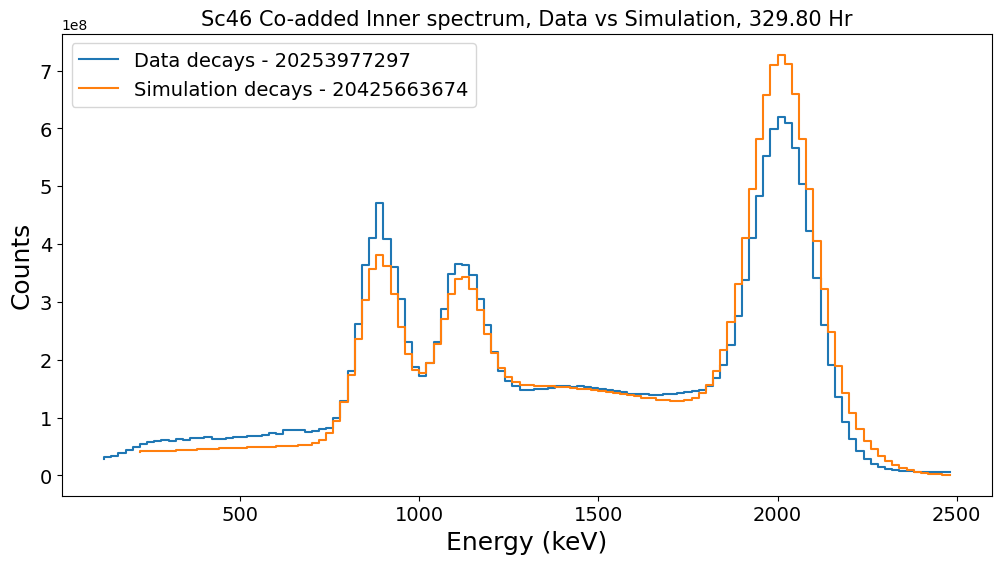

In [97]:
plt.step(Bins[1:], n_EnergyInner_NVeto, label = "Data decays - %d"%n_EnergyInner_NVeto.sum())
plt.step(bins_combined[1:][10:125], sim_energy_match_Inner[10:125], label = "Simulation decays - %d"%sim_energy_match_Inner[10:125].sum())
label("Energy (keV)", "Counts", 12, 6)
source = "Sc46"
n, bins = n_EnergyAll_NVeto, Bins[1:]
# gaus_fit(1850, 2200, 1200, 8e8, nm = "keV")
# amp1, mu1, sigma1, fig = gaus_fit(770, 990, 200, 3e8, nm = "keV")
# amp2, mu2, sigma2, fig = gaus_fit(1050, 1230, 1000, 5e8, nm = "keV")
plt.legend(fontsize = 14)
# plt.xlim(10, 1000)
plt.title(f"{source} Co-added Inner spectrum, Data vs Simulation, {Time/3600:.2f} Hr", fontsize = 15)
plt.savefig("%s/Energy_%s_Inner_DS.jpg"%(save_folder_each, source), dpi = 300)

In [95]:
save_folder_each

'../RUN5/Sc46/Figures/Take4_2\\Folder_21'

In [44]:
Gamma_single_data = np.zeros(2)
for j, bin_energy in enumerate(Bins[1:]):
    if mu1 - 1.5 * sigma1 < bin_energy < mu1 + 1.5 * sigma1:
        Gamma_single_data[0] += n_EnergyAll_NVeto[j]
    elif mu2 - 1.5 * sigma2 < bin_energy < mu2 + 1.5 * sigma2:
        Gamma_single_data[1] += n_EnergyAll_NVeto[j]


Gamma_single_simulation = np.zeros(2)
for j, bin_energy in enumerate(bins_combined[1:]):
    if mu1 - 1.5 * sigma1 < bin_energy < mu1 + 1.5 * sigma1:
        Gamma_single_simulation[0] += sim_energy_match_All[j]
    elif mu2 - 1.5 * sigma2 < bin_energy < mu2 + 1.5 * sigma2:
        Gamma_single_simulation[1] += sim_energy_match_All[j]

In [47]:
nevents_data = n_EnergyAll_NVeto.sum()
nevents_simulation = sim_energy_match_All.sum()
Gamma_single_data/ nevents_data*100, Gamma_single_simulation/ nevents_simulation*100

(array([8.07608644, 9.52224106]), array([5.55897075, 7.24951619]))